In [1]:
!pip install torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, ToTensor

from torchmetrics import Accuracy as VAccuracy
from tqdm import tqdm
import random
from glob import glob
from PIL import Image

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
! pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"katjaperesypkina","key":"36afabc3c361b174c0ca9a49ca0bd468"}'}

In [4]:
import os

# Создаём директорию .kaggle
os.makedirs("~/.kaggle", exist_ok=True)

# Перемещаем kaggle.json в эту директорию
!mv kaggle.json ~/.kaggle/

# Задаём права доступа
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot move 'kaggle.json' to '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d sujaykapadnis/smoking
!unzip smoking.zip -d smoking_data

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/smoking
License(s): Attribution 4.0 International (CC BY 4.0)
100% 63.8M/63.8M [00:04<00:00, 21.4MB/s]
100% 63.8M/63.8M [00:04<00:00, 15.8MB/s]
Archive:  smoking.zip
  inflating: smoking_data/Testing/Testing/notsmoking_0004.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0014.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0018.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0026.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0032.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0036.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0041.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0049.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0053.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0058.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0062.jpg  
  inflating: smoking_data/Testing/Testing/notsmoking_0069.jpg  
  infla

In [6]:
train_path = os.path.join('smoking_data', 'Training', 'Training')
label_list = ['notsmoking', 'smoking']

data = []

img_list = glob(os.path.join(train_path, '*.jpg'))
for img in img_list:
    file_name = os.path.basename(img)
    if file_name.startswith(label_list[0]):
        data.append({"path": img, "class_id": 0})
    elif file_name.startswith(label_list[1]):
        data.append({"path": img, "class_id": 1})

train_df = pd.DataFrame(data)

train_df.head()

,path,class_id
0,smoking_data/Training/Training/smoking_0259.jpg,1
1,smoking_data/Training/Training/notsmoking_0231...,0
2,smoking_data/Training/Training/smoking_0114.jpg,1
3,smoking_data/Training/Training/notsmoking_0438...,0
4,smoking_data/Training/Training/smoking_0120.jpg,1


In [7]:
test_path = os.path.join('smoking_data', 'Validation', 'Validation')
data = []
img_list = glob(os.path.join(test_path, '*.jpg'))

for img in img_list:
    file_name = os.path.basename(img)
    if file_name.startswith(label_list[0]):
        data.append({"path": img, "class_id": 0})
    elif file_name.startswith(label_list[1]):
        data.append({"path": img, "class_id": 1})

test_df = pd.DataFrame(data)


In [ ]:
test_df.head()

,path,class_id
0,smoking_data/Validation/Validation/smoking_041...,1
1,smoking_data/Validation/Validation/smoking_046...,1
2,smoking_data/Validation/Validation/notsmoking_...,0
3,smoking_data/Validation/Validation/smoking_040...,1
4,smoking_data/Validation/Validation/notsmoking_...,0


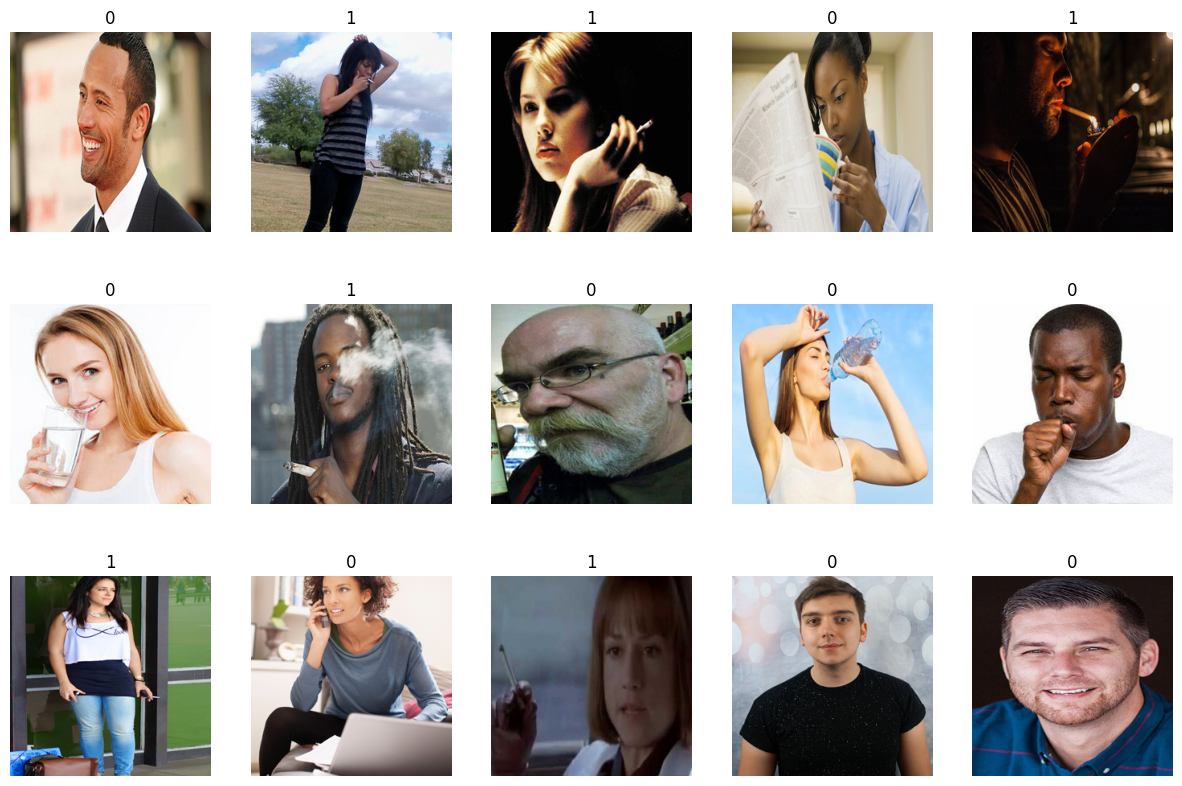

In [ ]:
show_imgs = 15
idx = np.random.randint(0,len(train_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['class_id'])
    ax.set_axis_off()

In [8]:
image_sizes = []

for path in train_df['path']:
    with Image.open(path) as img:
        image_sizes.append(img.size)  # .size возвращает (ширина, высота)

# Преобразуем список размеров в DataFrame для анализа
size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

# Выводим статистику размеров изображений
print(size_df.describe())

       width  height
count  716.0   716.0
mean   250.0   250.0
std      0.0     0.0
min    250.0   250.0
25%    250.0   250.0
50%    250.0   250.0
75%    250.0   250.0
max    250.0   250.0


все картинки 250 x 250


In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # Преобразует изображение в RGB
    transforms.ToTensor()  # Преобразует в тензор [C, H, W]
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx]['path']
        with Image.open(path) as img:
            if self.transform:
                img = self.transform(img)
        label = self.dataframe.iloc[idx]['class_id']
        return img, label

train_dataset = CustomDataset(train_df, transform)
test_dataset = CustomDataset(test_df, transform)

In [10]:
def estimate_mean_std(dataset) -> tuple[torch.Tensor, torch.Tensor]:
    channels_sum, channels_squared_sum, num_pixels = torch.zeros(3), torch.zeros(3), 0

    for sample, _ in dataset:
        if sample.ndim != 3:  #сначала появлялась ошибка из-за неверного количества измерений, добавила проверку, но так и не поняла, что не так было
            raise ValueError(f"Unexpected sample shape: {sample.shape}")

        # Суммируем значения пикселей по каждому каналу
        channels_sum += torch.sum(sample, dim=[1, 2])  # [C, H, W]
        channels_squared_sum += torch.sum(sample ** 2, dim=[1, 2])

        # Увеличиваем счётчик пикселей
        num_pixels += sample.size(1) * sample.size(2)

    # Вычисляем среднее и стандартное отклонение
    mean = channels_sum / num_pixels
    std = (channels_squared_sum / num_pixels - mean ** 2) ** 0.5

    return mean, std

In [11]:
mean, std = estimate_mean_std(train_dataset)
mean, std

(tensor([0.5039, 0.4534, 0.4193]), tensor([0.3191, 0.3077, 0.3107]))

In [12]:
mean2, std2 = estimate_mean_std(test_dataset)
mean2, std2

(tensor([0.4914, 0.4372, 0.4043]), tensor([0.3203, 0.2998, 0.2999]))

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean2, std2)
    ]),
}

In [14]:
train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
test_dataset = CustomDataset(test_df, transform=data_transforms['test'])

In [15]:
generator = torch.Generator()
generator.manual_seed(42)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.70, 0.3], generator=generator)

In [16]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [17]:
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
def train(model, optimizer, train_dataloader, val_dataloader, device, n_epochs=5):
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_train_loss = []
        for x_train, y_train in train_dataloader:
            x_train, y_train = x_train.to(device), y_train.to(device)

            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_loss.append(loss.item())

        train_losses.append(np.mean(epoch_train_loss))

        if epoch % 1 == 0:
            model.eval()
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in val_dataloader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.item())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

            val_losses.append(np.mean(val_loss))
            val_accuracies.append(np.mean(val_accuracy))
            if epoch % 10 == 0:
              print(f"Epoch: {epoch}\tTrain loss: {train_losses[-1]:.4f}\tVal loss: {val_losses[-1]:.4f}\tAccuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

In [20]:
def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
def test(model, test_dataloader, device):
  model.eval()
  test_loss = []
  test_accuracy = []
  with torch.no_grad():
    for x_val, y_val in test_dataloader:
      x_val, y_val = x_val.to(device), y_val.to(device)
      y_pred = model(x_val)
      loss = F.cross_entropy(y_pred, y_val)
      test_loss.append(loss.item())
      test_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

  print(f"loss: {np.mean(test_loss)}\taccuracy: {np.mean(test_accuracy)}")

Для начала взяла модель из тетради с кошками, только добавила рассчет размера входа для линейного слоя.

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super().__init__()
        self.input_size = input_size  # Сохраняем размер входа

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  # 3 канала, 10 ядер, ядро 5x5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # 10 каналов, 20 ядер, ядро 5x5
        self.pool = nn.MaxPool2d(2)  # Макс-пулинг: уменьшаем размер на 2

        # Полносвязные слои
        self.calculate_flatten_size()  # Вычисляем размер выхода после сверточных слоев
        self.fc1 = nn.Linear(self.flatten_size, 128)  # Полносвязный слой
        self.fc2 = nn.Linear(128, num_classes)  # Выходной слой

    def calculate_flatten_size(self):
        with torch.no_grad():
            # Создаем тензор с размерами входного изображения
            x = torch.zeros(1, 3, *self.input_size)  # Batch=1, Channels=3
            # Применяем сверточные слои и пулинг
            x = F.relu(self.conv1(x))  # Первый сверточный слой
            x = self.pool(F.relu(self.conv2(x)))  # Второй сверточный слой + пулинг
            self.flatten_size = x.numel()  # Количество элементов в тензоре после выравнивания

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Выравнивание для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Я взяла модель (в целом примерно такую же, но в ней проще менять  функцию активации) и подсмотрела варианты экспериментов в этом семинаре вышки: https://github.com/nirtake/iad-deep-learning/blob/master/2024/seminars/03.%20Image%20Classification/03_Image_Classification.ipynb


In [ ]:
class Model_vgg(nn.Module):
  def __init__(self, input_size, activation=nn.ReLU):
    super().__init__()
    self.input_size = input_size
    self.activation = activation
    self.vgg = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        self.activation(),
        nn.Conv2d(16, 16, 3, padding=1),
        self.activation(),
        nn.MaxPool2d(2, stride=2)
    )

    self.calculate_flatten_size()  # Вычисляем размер выхода после сверточных слоев
    self.fc1 = nn.Linear(self.flatten_size, 128)  # Полносвязный слой
    self.act = self.activation()
    self.fc2 = nn.Linear(128, 2)  # Выходной слой

  def calculate_flatten_size(self):
          with torch.no_grad():
              # Создаем тензор с размерами входного изображения
              x = torch.zeros(1, 3, *self.input_size)  # Batch=1, Channels=3
              x = self.vgg(x)
              self.flatten_size = x.numel()  # Количество элементов в тензоре после выравнивания

  def forward(self, x):
    x = self.vgg(x)
    x = nn.Flatten()(x)
    x = self.act(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
set_random_seed(53)
model = BaseModel(input_size=(250, 250))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 1.1896130868366785	accuracy: 0.705607476635514
Epoch: 20	loss: 1.4191671184131078	accuracy: 0.719626168224299
Epoch: 30	loss: 1.5099946430751257	accuracy: 0.7102803738317757
Epoch: 40	loss: 1.5814264501844133	accuracy: 0.7149532710280374
Epoch: 50	loss: 1.6373044082096644	accuracy: 0.7149532710280374
Epoch: 60	loss: 1.6884523289544242	accuracy: 0.7149532710280374
Epoch: 70	loss: 1.7293620620455061	accuracy: 0.7149532710280374
Epoch: 80	loss: 1.763315967151097	accuracy: 0.7102803738317757
Epoch: 90	loss: 1.7957814250673567	accuracy: 0.705607476635514
Epoch: 100	loss: 1.8209176915032523	accuracy: 0.7102803738317757


In [ ]:
# Убедимся, что модель на правильном устройстве
model = BaseModel(input_size=(250, 250))
model.to(DEVICE)  # Переносим модель на устройство

# Создаем входной тензор и переносим его на то же устройство
input_tensor = torch.rand((1, 3, 250, 250)).to(DEVICE)

# Прямой проход
output = model(input_tensor)
print(output.shape)  # Ожидаемый вывод: torch.Size([1, 2]) для 2 классов


torch.Size([1, 2])


In [ ]:
set_random_seed(53)
model2 = Model_vgg(input_size=(250, 250))
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model2, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 1.0479869416781835	accuracy: 0.719626168224299
Epoch: 20	loss: 1.2174981640917915	accuracy: 0.719626168224299
Epoch: 30	loss: 1.3078631524528777	accuracy: 0.7149532710280374
Epoch: 40	loss: 1.3853891151291984	accuracy: 0.7149532710280374
Epoch: 50	loss: 1.445745444723538	accuracy: 0.7102803738317757
Epoch: 60	loss: 1.4957764404160636	accuracy: 0.7102803738317757
Epoch: 70	loss: 1.5411871416228158	accuracy: 0.705607476635514
Epoch: 80	loss: 1.5840656501906258	accuracy: 0.7009345794392523
Epoch: 90	loss: 1.6219333154814584	accuracy: 0.705607476635514
Epoch: 100	loss: 1.6591110059193201	accuracy: 0.7009345794392523


In [ ]:
set_random_seed(53)
model3 = Model_vgg(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model3, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.0004	Val loss: 1.1274	Accuracy: 0.7196
Epoch: 20	Train loss: 0.0000	Val loss: 1.3409	Accuracy: 0.7290
Epoch: 30	Train loss: 0.0000	Val loss: 1.4437	Accuracy: 0.7290
Epoch: 40	Train loss: 0.0000	Val loss: 1.5130	Accuracy: 0.7243
Epoch: 50	Train loss: 0.0000	Val loss: 1.5636	Accuracy: 0.7243
Epoch: 60	Train loss: 0.0000	Val loss: 1.6091	Accuracy: 0.7290
Epoch: 70	Train loss: 0.0000	Val loss: 1.6448	Accuracy: 0.7290
Epoch: 80	Train loss: 0.0000	Val loss: 1.6772	Accuracy: 0.7290
Epoch: 90	Train loss: 0.0000	Val loss: 1.7060	Accuracy: 0.7290
Epoch: 100	Train loss: 0.0000	Val loss: 1.7337	Accuracy: 0.7290


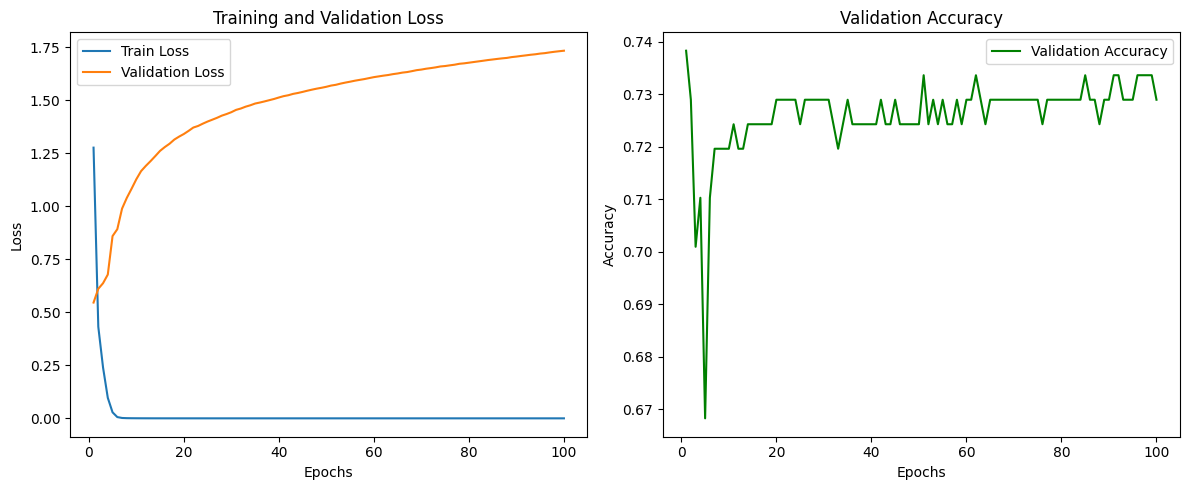

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
set_random_seed(53)
model4 = Model_vgg(input_size=(250, 250), activation=nn.ELU)
optimizer = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model4, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 1.093050948211125	accuracy: 0.705607476635514
Epoch: 20	loss: 1.347906197820391	accuracy: 0.7009345794392523
Epoch: 30	loss: 1.4783312790095806	accuracy: 0.6915887850467289
Epoch: 40	loss: 1.5678353421390057	accuracy: 0.677570093457944
Epoch: 50	loss: 1.6237821797175067	accuracy: 0.677570093457944
Epoch: 60	loss: 1.6680659082319056	accuracy: 0.677570093457944
Epoch: 70	loss: 1.7241522228079182	accuracy: 0.6728971962616822
Epoch: 80	loss: 1.748695222394807	accuracy: 0.6728971962616822
Epoch: 90	loss: 1.7876968043191093	accuracy: 0.6728971962616822
Epoch: 100	loss: 1.8284129670688085	accuracy: 0.677570093457944


In [ ]:
set_random_seed(53)
model5 = Model_vgg(input_size=(250, 250), activation=nn.SELU)
optimizer = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model5, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 1.2688968202897482	accuracy: 0.6869158878504673
Epoch: 20	loss: 1.622174316218921	accuracy: 0.6962616822429907
Epoch: 30	loss: 1.7688899976866586	accuracy: 0.7102803738317757
Epoch: 40	loss: 1.8723005716289793	accuracy: 0.7102803738317757
Epoch: 50	loss: 1.9659607176269804	accuracy: 0.705607476635514
Epoch: 60	loss: 2.04643566267831	accuracy: 0.7009345794392523
Epoch: 70	loss: 2.1155525786536082	accuracy: 0.7009345794392523
Epoch: 80	loss: 2.176587415593011	accuracy: 0.6869158878504673
Epoch: 90	loss: 2.240986487695149	accuracy: 0.6915887850467289
Epoch: 100	loss: 2.2906944368566786	accuracy: 0.6869158878504673


LeakyReLU оказалась лучшей.  
Проверим еще несколько оптимизаторов.

In [ ]:
set_random_seed(53)
model3 = Model_vgg(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.AdamW(model3.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model3, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 1.048813326018197	accuracy: 0.705607476635514
Epoch: 20	loss: 1.3233463381017958	accuracy: 0.7242990654205608
Epoch: 30	loss: 1.4319194981030055	accuracy: 0.7336448598130841
Epoch: 40	loss: 1.5118935448782784	accuracy: 0.7242990654205608
Epoch: 50	loss: 1.5620914782796587	accuracy: 0.719626168224299
Epoch: 60	loss: 1.5970919302531652	accuracy: 0.7336448598130841
Epoch: 70	loss: 1.6282187700271606	accuracy: 0.7336448598130841
Epoch: 80	loss: 1.6580234127385276	accuracy: 0.7336448598130841
Epoch: 90	loss: 1.683614432811737	accuracy: 0.7336448598130841
Epoch: 100	loss: 1.7128554795469557	accuracy: 0.719626168224299


In [ ]:
set_random_seed(53)
model3 = Model_vgg(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.SGD(model3.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [ ]:
train(model3, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	loss: 0.6761307386415345	accuracy: 0.7242990654205608
Epoch: 20	loss: 1.2638011606676238	accuracy: 0.7102803738317757
Epoch: 30	loss: 1.474905407854489	accuracy: 0.7102803738317757
Epoch: 40	loss: 1.6000470614859037	accuracy: 0.705607476635514
Epoch: 50	loss: 1.677974392260824	accuracy: 0.705607476635514
Epoch: 60	loss: 1.7283500347818648	accuracy: 0.705607476635514
Epoch: 70	loss: 1.7698522891317094	accuracy: 0.705607476635514
Epoch: 80	loss: 1.814025376524244	accuracy: 0.705607476635514
Epoch: 90	loss: 1.8433058261871338	accuracy: 0.705607476635514
Epoch: 100	loss: 1.8755121912275041	accuracy: 0.705607476635514


Лучше, чем с Adam не получилось.

In [ ]:
test(model3, test_loader, DEVICE)

loss: 1.9944740533828735	accuracy: 0.7111111111111111


Попробавала добавить BatchNorm  
1. после каждой свертки и линейного слоя
2. только после линейных слоев

In [ ]:
class Model_vgg2(nn.Module):
  def __init__(self, input_size, activation=nn.ReLU):
    super().__init__()
    self.input_size = input_size
    self.activation = activation
    self.vgg = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.BatchNorm2d(16),
        self.activation(),
        nn.Conv2d(16, 16, 3, padding=1),
        nn.BatchNorm2d(16),
        self.activation(),
        nn.MaxPool2d(2, stride=2)
    )

    self.calculate_flatten_size()  # Вычисляем размер выхода после сверточных слоев
    self.fc1 = nn.Linear(self.flatten_size, 128)  # Полносвязный слой
    self.norm = nn.BatchNorm1d(128)
    self.act = self.activation()
    #self.dropout = nn.Dropout(0.3)
    self.fc2 = nn.Linear(128, 2)  # Выходной слой

  def calculate_flatten_size(self):
          with torch.no_grad():
              # Создаем тензор с размерами входного изображения
              x = torch.zeros(1, 3, *self.input_size)  # Batch=1, Channels=3
              x = self.vgg(x)
              self.flatten_size = x.numel()  # Количество элементов в тензоре после выравнивания

  def forward(self, x):
    x = self.vgg(x)
    x = nn.Flatten()(x)
    x = self.act(self.norm(self.fc1(x)))
    x = self.fc2(x)
    return x

In [ ]:
set_random_seed(53)
model6 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model6, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.0453	Val loss: 0.7559	Accuracy: 0.6963
Epoch: 20	Train loss: 0.0249	Val loss: 0.8650	Accuracy: 0.7009
Epoch: 30	Train loss: 0.0075	Val loss: 0.9648	Accuracy: 0.6682
Epoch: 40	Train loss: 0.0127	Val loss: 1.0802	Accuracy: 0.6963
Epoch: 50	Train loss: 0.0248	Val loss: 1.1320	Accuracy: 0.6963
Epoch: 60	Train loss: 0.0154	Val loss: 1.0776	Accuracy: 0.7009
Epoch: 70	Train loss: 0.0029	Val loss: 1.1637	Accuracy: 0.7103
Epoch: 80	Train loss: 0.0038	Val loss: 1.3061	Accuracy: 0.6636
Epoch: 90	Train loss: 0.0037	Val loss: 1.2288	Accuracy: 0.7150
Epoch: 100	Train loss: 0.0018	Val loss: 1.3366	Accuracy: 0.6822


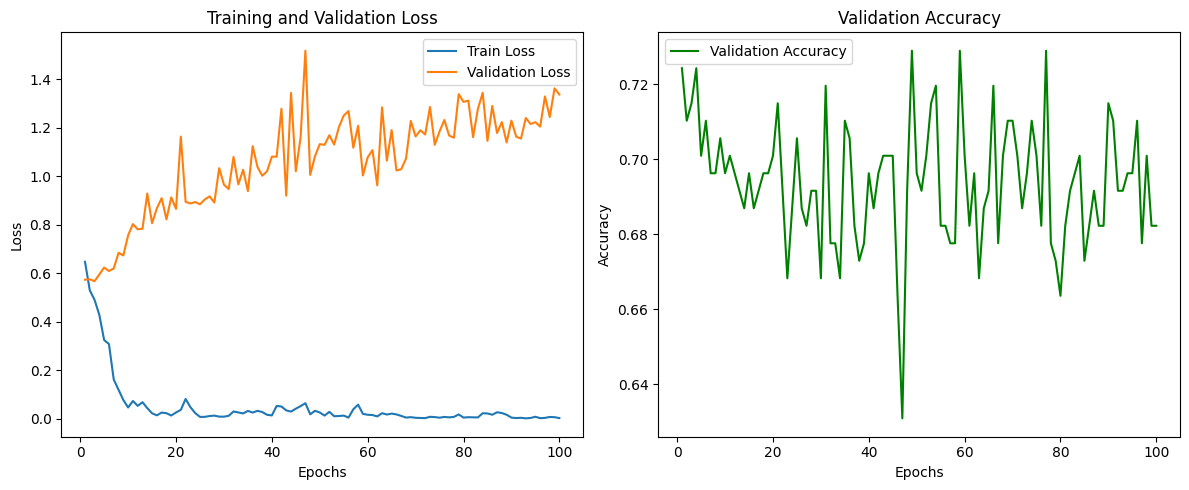

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
set_random_seed(53)
model7 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model7, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.0266	Val loss: 0.7931	Accuracy: 0.7150
Epoch: 20	Train loss: 0.0108	Val loss: 1.0738	Accuracy: 0.6963
Epoch: 30	Train loss: 0.0057	Val loss: 1.0503	Accuracy: 0.6682
Epoch: 40	Train loss: 0.0020	Val loss: 1.2369	Accuracy: 0.6963
Epoch: 50	Train loss: 0.0234	Val loss: 1.0872	Accuracy: 0.6449
Epoch: 60	Train loss: 0.0051	Val loss: 1.2328	Accuracy: 0.6682
Epoch: 70	Train loss: 0.0013	Val loss: 1.1356	Accuracy: 0.6682
Epoch: 80	Train loss: 0.0005	Val loss: 1.3334	Accuracy: 0.6589
Epoch: 90	Train loss: 0.0063	Val loss: 1.3807	Accuracy: 0.7196
Epoch: 100	Train loss: 0.0007	Val loss: 1.3771	Accuracy: 0.6822


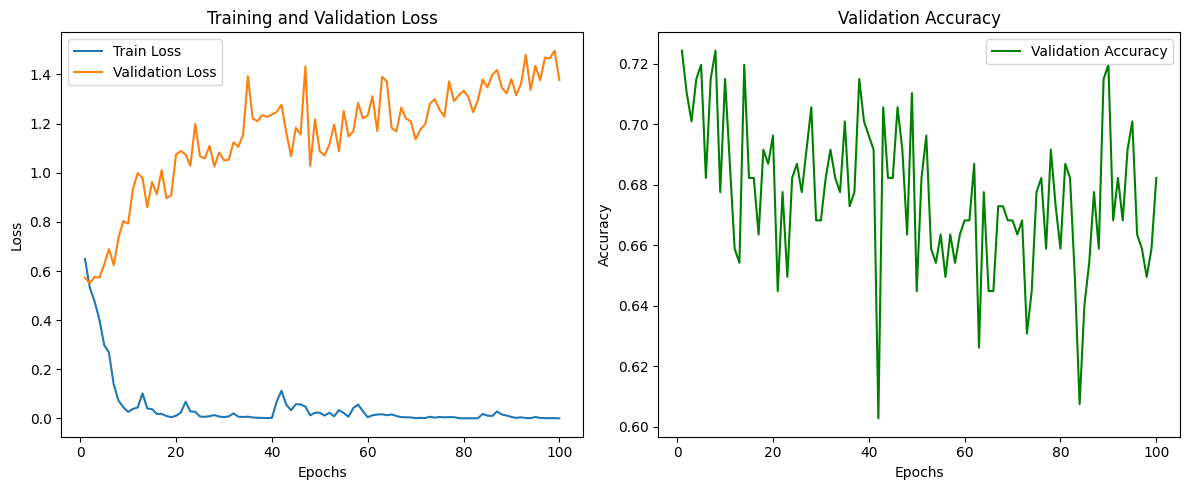

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
test(model6, test_loader, DEVICE)

loss: 1.1212333689133327	accuracy: 0.7333333333333333


На тесте у модели с BatchNorm после сверток и линейных слоев результат оказался лучше.

In [ ]:
test(model7, test_loader, DEVICE)

loss: 1.149360782156388	accuracy: 0.6944444444444444


Попробовала добавить дропаут  
1. вместе с BatchNorm
2. без BatchNorm

In [ ]:
set_random_seed(53) #BarchNorm, dropout 0.5
model8 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model8.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model8, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.1381	Val loss: 0.6329	Accuracy: 0.7150
Epoch: 20	Train loss: 0.0365	Val loss: 1.0768	Accuracy: 0.6308
Epoch: 30	Train loss: 0.0239	Val loss: 0.9147	Accuracy: 0.6963
Epoch: 40	Train loss: 0.0158	Val loss: 0.9876	Accuracy: 0.7103
Epoch: 50	Train loss: 0.0590	Val loss: 0.9769	Accuracy: 0.7056
Epoch: 60	Train loss: 0.0050	Val loss: 1.1200	Accuracy: 0.6963
Epoch: 70	Train loss: 0.0109	Val loss: 1.1729	Accuracy: 0.6963
Epoch: 80	Train loss: 0.0031	Val loss: 1.1694	Accuracy: 0.7009
Epoch: 90	Train loss: 0.0281	Val loss: 1.1745	Accuracy: 0.7056
Epoch: 100	Train loss: 0.0049	Val loss: 1.2481	Accuracy: 0.6963


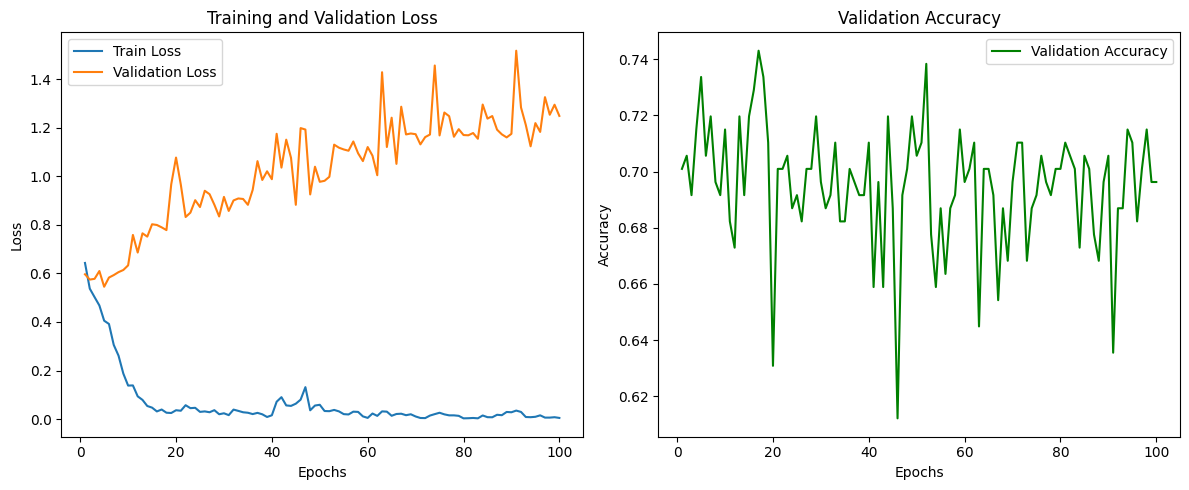

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
set_random_seed(53) #без BarchNorm, dropout 0.5
model9 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model9.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model9, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.0078	Val loss: 0.8391	Accuracy: 0.7103
Epoch: 20	Train loss: 0.0846	Val loss: 1.0890	Accuracy: 0.6869
Epoch: 30	Train loss: 0.0003	Val loss: 1.6119	Accuracy: 0.6916
Epoch: 40	Train loss: 0.0003	Val loss: 1.8488	Accuracy: 0.6869
Epoch: 50	Train loss: 0.0000	Val loss: 1.7894	Accuracy: 0.6822
Epoch: 60	Train loss: 0.0002	Val loss: 1.6133	Accuracy: 0.6729
Epoch: 70	Train loss: 0.0000	Val loss: 1.8458	Accuracy: 0.6776
Epoch: 80	Train loss: 0.0000	Val loss: 2.0030	Accuracy: 0.6869
Epoch: 90	Train loss: 0.0000	Val loss: 2.0702	Accuracy: 0.6963
Epoch: 100	Train loss: 0.0000	Val loss: 2.1291	Accuracy: 0.6963


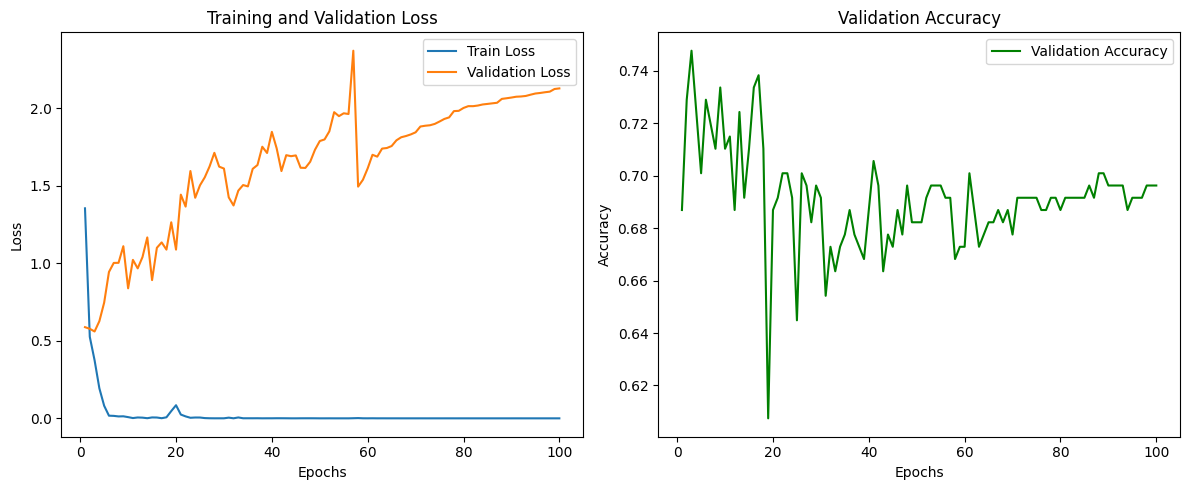

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
test(model8, test_loader, DEVICE)

loss: 0.9557072867949804	accuracy: 0.7277777777777777


In [ ]:
test(model9, test_loader, DEVICE)

loss: 1.8244738578796387	accuracy: 0.7277777777777777


In [ ]:
set_random_seed(53) #BarchNorm, dropout 0.3
model10 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model10.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model10, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.0889	Val loss: 0.7153	Accuracy: 0.7243
Epoch: 20	Train loss: 0.0269	Val loss: 0.8297	Accuracy: 0.6963
Epoch: 30	Train loss: 0.0179	Val loss: 0.8525	Accuracy: 0.7103
Epoch: 40	Train loss: 0.0195	Val loss: 1.1431	Accuracy: 0.6776
Epoch: 50	Train loss: 0.0258	Val loss: 1.0296	Accuracy: 0.7103
Epoch: 60	Train loss: 0.0063	Val loss: 1.1760	Accuracy: 0.7009
Epoch: 70	Train loss: 0.0032	Val loss: 1.2046	Accuracy: 0.6916
Epoch: 80	Train loss: 0.0058	Val loss: 1.2374	Accuracy: 0.6776
Epoch: 90	Train loss: 0.0020	Val loss: 1.3271	Accuracy: 0.6589
Epoch: 100	Train loss: 0.0061	Val loss: 1.3102	Accuracy: 0.6869


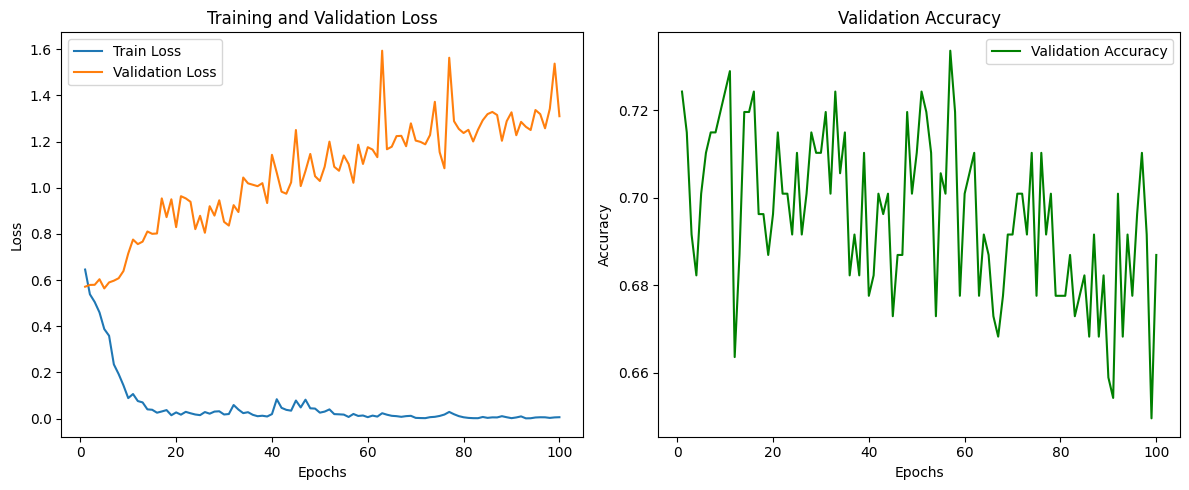

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
test(model10, test_loader, DEVICE)

loss: 1.3102800125877063	accuracy: 0.7277777777777777


Решила попробавать аугментацию изображений. Взяла transforms, в котором меняются цвета и поворачивается изображение.

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean2, std2)
    ]),
}

In [23]:
train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
test_dataset = CustomDataset(test_df, transform=data_transforms['test'])

In [24]:
generator = torch.Generator()
generator.manual_seed(42)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.70, 0.3], generator=generator)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
set_random_seed(53)
model3 = Model_vgg(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

NameError: name 'Model_vgg' is not defined

In [ ]:
train_losses, val_losses, val_accuracies = train(model3, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.3705	Val loss: 0.6856	Accuracy: 0.6589
Epoch: 20	Train loss: 0.3524	Val loss: 0.8268	Accuracy: 0.6215
Epoch: 30	Train loss: 0.1095	Val loss: 1.2013	Accuracy: 0.6869
Epoch: 40	Train loss: 0.0845	Val loss: 1.2818	Accuracy: 0.6308
Epoch: 50	Train loss: 0.0372	Val loss: 1.5440	Accuracy: 0.7056


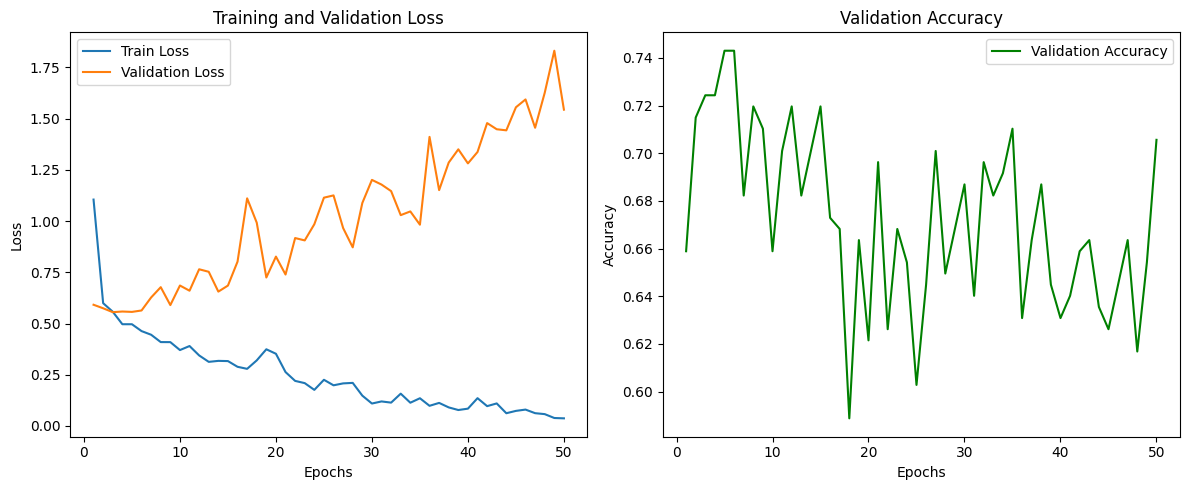

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
test(model3, test_loader, DEVICE)

loss: 1.3472215756773949	accuracy: 0.7111111111111111


In [ ]:
set_random_seed(53)
model6 = Model_vgg2(input_size=(250, 250), activation=nn.LeakyReLU)
optimizer = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses, val_losses, val_accuracies = train(model6, optimizer, train_loader, val_loader, DEVICE, EPOCHS)

Epoch: 10	Train loss: 0.4288	Val loss: 0.5882	Accuracy: 0.6822
Epoch: 20	Train loss: 0.3329	Val loss: 0.6936	Accuracy: 0.7243
Epoch: 30	Train loss: 0.2598	Val loss: 1.1725	Accuracy: 0.6075
Epoch: 40	Train loss: 0.1885	Val loss: 0.9578	Accuracy: 0.6542
Epoch: 50	Train loss: 0.1337	Val loss: 1.0337	Accuracy: 0.6542


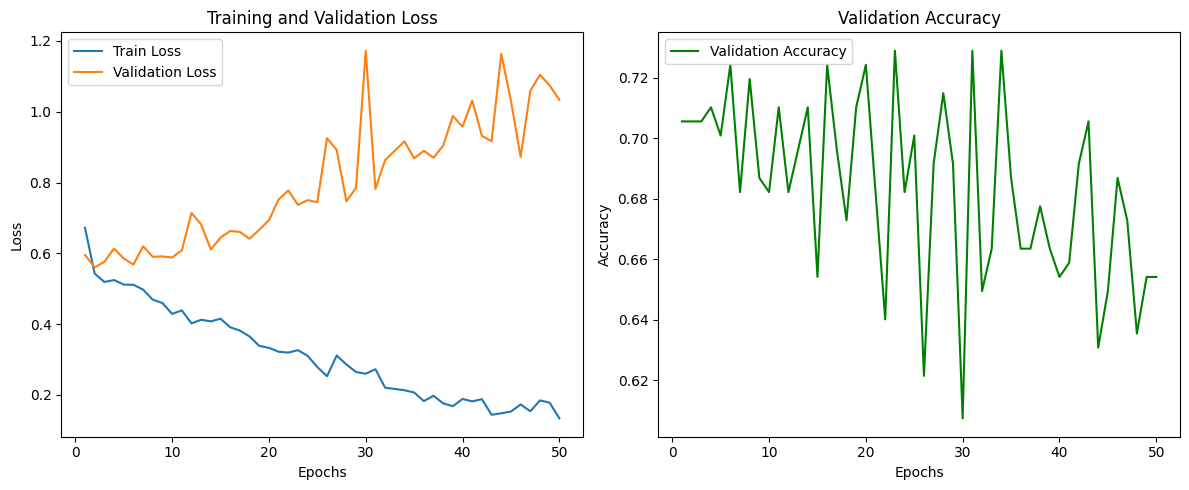

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [ ]:
test(model6, test_loader, DEVICE)

loss: 0.9294269979000092	accuracy: 0.75


На последок взяла модель побольше из того же семинара. Обучала на аугментированных данных.

In [32]:
set_random_seed(53)
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),  # Вход: (3, 250, 250), Выход: (16, 250, 250)
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),  # Вход: (16, 250, 250), Выход: (16, 250, 250)
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Вход: (16, 250, 250), Выход: (16, 125, 125)

    nn.Conv2d(16, 32, 3, padding=1),  # Вход: (16, 125, 125), Выход: (32, 125, 125)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),  # Вход: (32, 125, 125), Выход: (32, 125, 125)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Вход: (32, 125, 125), Выход: (32, 62, 62)

    nn.Conv2d(32, 64, 3, padding=1),  # Вход: (32, 62, 62), Выход: (64, 62, 62)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),  # Вход: (64, 62, 62), Выход: (64, 62, 62)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Вход: (64, 62, 62), Выход: (64, 31, 31)

    nn.Flatten(),  # Вход: (64, 31, 31), Выход: (64 * 31 * 31)
    nn.Linear(64 * 31 * 31, 128),  # Полносвязный слой
    nn.BatchNorm1d(128),
    nn.ReLU(),
    #nn.Dropout(0.5),
    nn.Linear(128, 10),  # Выходной слой
)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [33]:
train_losses, val_losses, val_accuracies = train(model, optimizer, train_loader, val_loader, DEVICE, EPOCHS) #без дропаутов

Epoch: 10	Train loss: 0.4309	Val loss: 0.5877	Accuracy: 0.7150
Epoch: 20	Train loss: 0.3658	Val loss: 0.7090	Accuracy: 0.6776
Epoch: 30	Train loss: 0.3592	Val loss: 0.7135	Accuracy: 0.7009
Epoch: 40	Train loss: 0.2054	Val loss: 1.0340	Accuracy: 0.6963
Epoch: 50	Train loss: 0.1415	Val loss: 0.9927	Accuracy: 0.7103


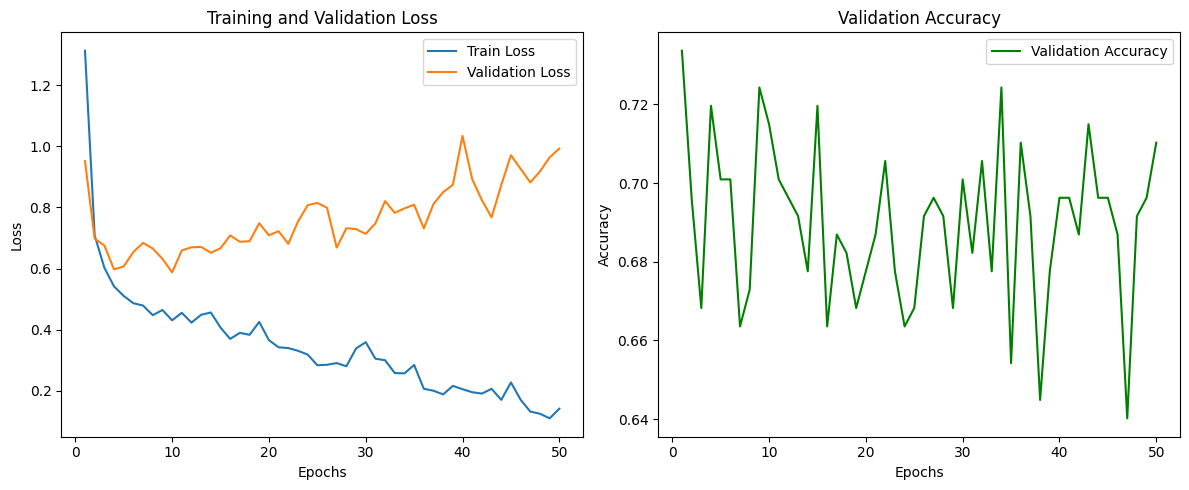

In [34]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [35]:
test(model, test_loader, DEVICE)

loss: 0.8511585419376692	accuracy: 0.75


In [27]:
train_losses, val_losses, val_accuracies = train(model, optimizer, train_loader, val_loader, DEVICE, EPOCHS) #с дропаутами

Epoch: 10	Train loss: 0.4631	Val loss: 0.5707	Accuracy: 0.7196
Epoch: 20	Train loss: 0.4189	Val loss: 0.6614	Accuracy: 0.6682
Epoch: 30	Train loss: 0.3531	Val loss: 0.6880	Accuracy: 0.7056
Epoch: 40	Train loss: 0.2607	Val loss: 0.9102	Accuracy: 0.6449
Epoch: 50	Train loss: 0.2295	Val loss: 0.8829	Accuracy: 0.6542


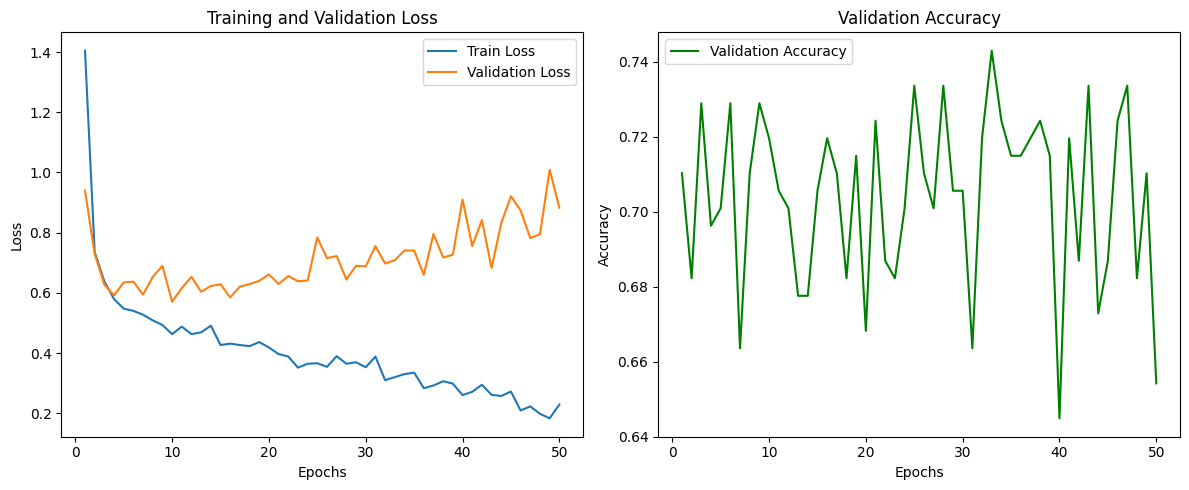

In [28]:
plot_training_curves(train_losses, val_losses, val_accuracies)

In [30]:
test(model, test_loader, DEVICE)

loss: 0.742555633187294	accuracy: 0.7277777777777777


Сильно повысить качество так и не получилось(  
Немного помогло (смотрела оценку на тесте): LeakyReLU, BatchNorm после каждой свертки и линейного слоя, аугментация.  
Увеличение числа сверток почти не повлияло на результат.  
Дропауты скорее ухудшали.

Датасет отсюда: https://www.kaggle.com/datasets/sujaykapadnis/smoking
